In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Dataset/train'
valid_path = 'Dataset/test'

# add preprocessing layer to the front of VGG
vgg = InceptionResNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

"""# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False"""

"# don't train existing weights\nfor layer in vgg.layers:\n  layer.trainable = False"

In [4]:
vgg.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

block17_20_mixed (Concatenate)  (None, 12, 12, 384)  0           activation_152[0][0]             
                                                                 activation_155[0][0]             
__________________________________________________________________________________________________
block17_20_conv (Conv2D)        (None, 12, 12, 1088) 418880      block17_20_mixed[0][0]           
__________________________________________________________________________________________________
block17_20 (Lambda)             (None, 12, 12, 1088) 0           block17_19_ac[0][0]              
                                                                 block17_20_conv[0][0]            
__________________________________________________________________________________________________
block17_20_ac (Activation)      (None, 12, 12, 1088) 0           block17_20[0][0]                 
__________________________________________________________________________________________________
conv2d_160

In [5]:
# useful for getting number of classes
folders = glob('Dataset/train/*')
folders

['Dataset/train/ritu', 'Dataset/train/vikash']

In [6]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [7]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


In [9]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

activation_171 (Activation)     (None, 5, 5, 192)    0           batch_normalization_171[0][0]    
__________________________________________________________________________________________________
activation_174 (Activation)     (None, 5, 5, 256)    0           batch_normalization_174[0][0]    
__________________________________________________________________________________________________
block8_3_mixed (Concatenate)    (None, 5, 5, 448)    0           activation_171[0][0]             
                                                                 activation_174[0][0]             
__________________________________________________________________________________________________
block8_3_conv (Conv2D)          (None, 5, 5, 2080)   933920      block8_3_mixed[0][0]             
__________________________________________________________________________________________________
block8_3 (Lambda)               (None, 5, 5, 2080)   0           block8_2_ac[0][0]                
          

In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 120 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [12]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
4/4 [==============================] - 65s 16s/step - loss: 0.5812 - accuracy: 0.7750 - val_loss: 2.7384e-05 - val_accuracy: 1.0000
Epoch 2/5
4/4 [==============================] - 60s 15s/step - loss: 3.2629e-04 - accuracy: 1.0000 - val_loss: 40.0359 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 64s 16s/step - loss: 5.5815e-06 - accuracy: 1.0000 - val_loss: 101.7347 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 65s 16s/step - loss: 1.6687e-05 - accuracy: 1.0000 - val_loss: 217.8445 - val_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 60s 15s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 379.1129 - val_accuracy: 0.5000


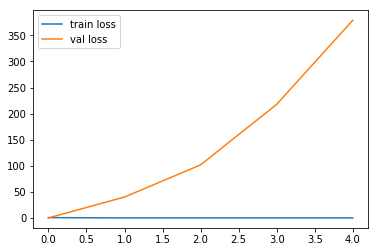

<Figure size 432x288 with 0 Axes>

In [13]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

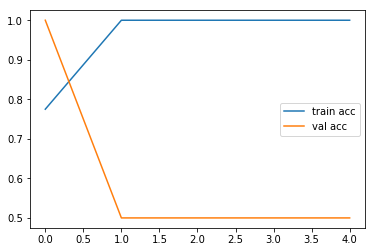

<Figure size 432x288 with 0 Axes>

In [14]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [18]:
import tensorflow as tf

from keras.models import load_model                                                                                 c        

model.save('facefeatures_vgg16_new_model.h5')

In [31]:
model.save('facefeatures_vgg19.h5')

In [15]:
model.save('facefeature_resnet.h5')